In [71]:
####################导入数据
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
color=sns.color_palette()
sns.set_style('darkgrid')
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestRegressor ######随机森林
from sklearn.model_selection import train_test_split  #####数据集划分
from sklearn.metrics import mean_absolute_error       ####评价指标MAE(辅助指标)
from sklearn.preprocessing import LabelEncoder       ####编码

from sklearn.linear_model import LinearRegression  #####线性回归
import xgboost as xgb
from sklearn.linear_model import Lasso  ####lasso回归

house_train = pd.read_csv('C:\\Users\\dell\\Desktop\\train_data.csv') 
house_test = pd.read_csv('C:\\Users\\dell\\Desktop\\test_a.csv')

In [72]:
#####################数据的探索性分析
#############数据整体探索
house_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41440 entries, 0 to 41439
Data columns (total 51 columns):
ID                    41440 non-null int64
area                  41440 non-null float64
rentType              41440 non-null object
houseType             41440 non-null object
houseFloor            41440 non-null object
totalFloor            41440 non-null int64
houseToward           41440 non-null object
houseDecoration       41440 non-null object
communityName         41440 non-null object
city                  41440 non-null object
region                41440 non-null object
plate                 41440 non-null object
buildYear             41440 non-null object
saleSecHouseNum       41440 non-null int64
subwayStationNum      41440 non-null int64
busStationNum         41440 non-null int64
interSchoolNum        41440 non-null int64
schoolNum             41440 non-null int64
privateSchoolNum      41440 non-null int64
hospitalNum           41440 non-null int64
drugStoreNum       

训练集数据共有51个变量，其中非数值型变量共有11个，因变量tradeMoney为数值型变量，对因变量的探索如下：

In [73]:
################对因变量的探索
house_train['tradeMoney'].describe()

count    4.144000e+04
mean     8.837074e+03
std      5.514287e+05
min      0.000000e+00
25%      2.800000e+03
50%      4.000000e+03
75%      5.500000e+03
max      1.000000e+08
Name: tradeMoney, dtype: float64

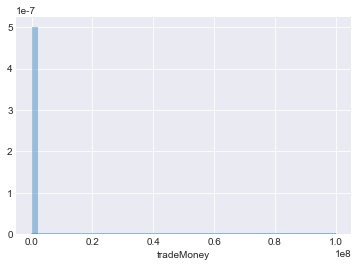

In [74]:
sns.distplot(house_train['tradeMoney'])

((array([-4.14859112, -3.94082745, -3.82747763, ...,  3.82747763,
          3.94082745,  4.14859112]),
  array([       0.  ,        0.  ,        0.  , ..., 10000000.  ,
         50000000.  , 99999999.99])),
 (19377.86675527431, 8837.074227557909, 0.03513817145173388))

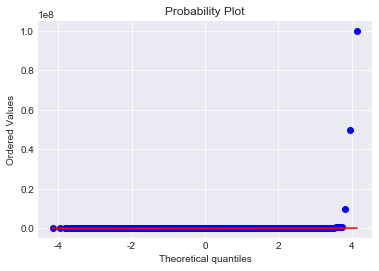

In [75]:
fig=plt.figure()
stats.probplot(house_train['tradeMoney'],plot=plt)

上面结果显示：因变量房屋价格具有较为明显的右偏性，且明显不符合正态分布，现对其进行取对数处理：

In [76]:
##############对因变量租金取对数
house_train['tradeMoney'] = np.log(house_train['tradeMoney'])

In [84]:
house_train = house_train.loc[house_train['tradeMoney'].notnull(),:]  ####去除因变量为空的值，共9行,属于异常值

In [79]:
#####################对自变量的数据探索
###########缺失值分析
all_data_na = (house_train.isnull().sum()/len(house_train))*100
all_data_na = pd.DataFrame({'缺失值占比':all_data_na})
all_data_na = all_data_na.loc[all_data_na['缺失值占比'] > 0,:] #####找出有缺失值的指标
all_data_na

,缺失值占比
pv,0.043436
uv,0.043436


训练集数据缺失值不多，仅有两个指标有缺失值，且缺失率仅为4.34%，从这个角度看数据质量较好，这里暂时不对有缺失值的做删除处理。

In [80]:
#####################离散变量分析
############对于离散变量，统计变量的unique值，以及不同unique值的个数：
unique_rentType = house_train.groupby('rentType')['rentType'].count()
unique_houseType = house_train.groupby('houseType')['houseType'].count()
unique_houseFloor = house_train.groupby('houseFloor')['houseFloor'].count()
unique_houseToward = house_train.groupby('houseToward')['houseToward'].count()
unique_houseDecoration = house_train.groupby('houseDecoration')['houseDecoration'].count()
unique_communityName = house_train.groupby('communityName')['communityName'].count()
unique_city = house_train.groupby('city')['city'].count()
unique_region = house_train.groupby('region')['region'].count()
unique_plate = house_train.groupby('plate')['plate'].count()
unique_buildYear = house_train.groupby('buildYear')['buildYear'].count()


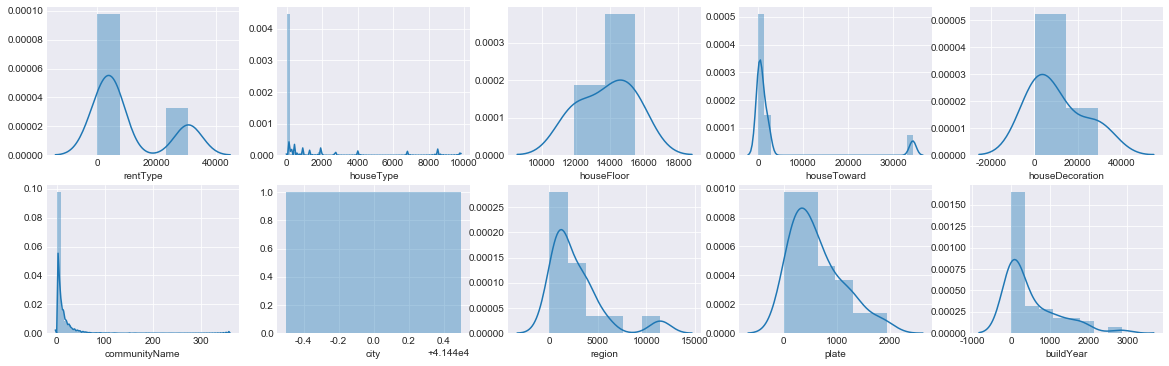

In [81]:
######################离散特征unique直方图分析
fig,axes = plt.subplots(2,5,figsize=(20,6))
sns.distplot(unique_rentType,ax=axes[0][0])
sns.distplot(unique_houseType,ax=axes[0][1])
sns.distplot(unique_houseFloor,ax=axes[0][2])
sns.distplot(unique_houseToward,ax=axes[0][3])
sns.distplot(unique_houseDecoration,ax=axes[0][4])
sns.distplot(unique_communityName,ax=axes[1][0])
sns.distplot(unique_city,ax=axes[1][1])
sns.distplot(unique_region,ax=axes[1][2])
sns.distplot(unique_plate,ax=axes[1][3])
sns.distplot(unique_buildYear,ax=axes[1][4])

从上图结果可知：大部分离散变量的unique值较少，数据较为集中的分布在几个离散变量中，下面取部分离散变量与房屋租金(y值)结合来看：

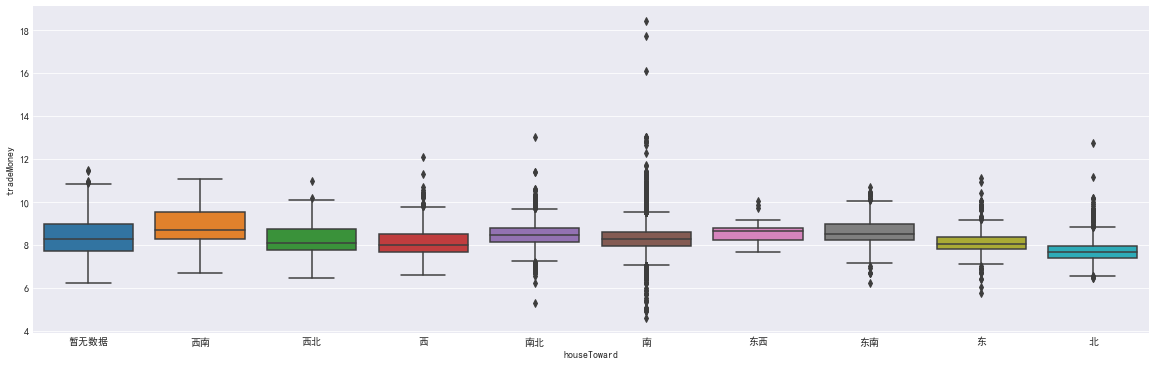

In [82]:
#####################房屋朝向与租金关系箱线图
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
fig,ax=plt.subplots(figsize=(20,6))
sns.boxplot(house_train['houseToward'],house_train['tradeMoney'],ax=ax)

上图结果显示：房屋朝南的租金普遍高(西南、南北、东南)于超北朝向(西北、北)，符合基本常识。

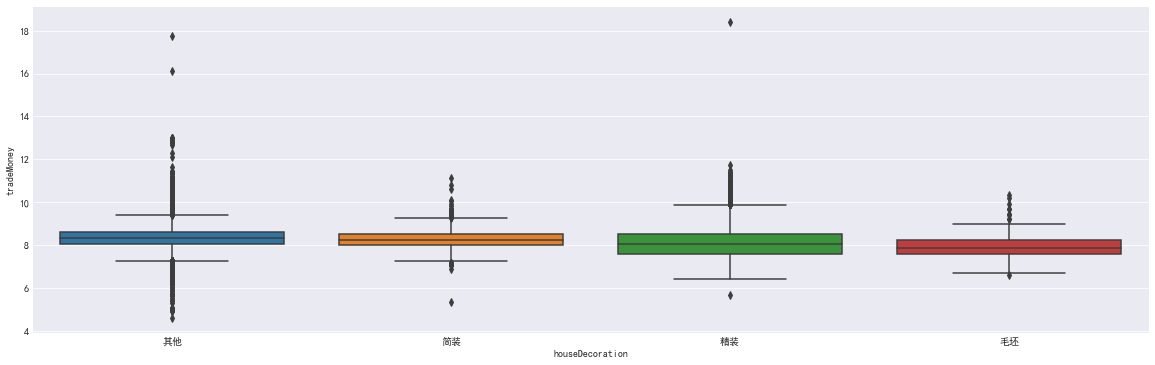

In [83]:
#####################装修情况与房屋租金关系箱线图
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
fig,ax=plt.subplots(figsize=(20,6))
sns.boxplot(house_train['houseDecoration'],house_train['tradeMoney'],ax=ax)

In [ ]:
上图结果显示：各种装修情况房屋租金相差不大，简装比精装的房屋价格还要高。

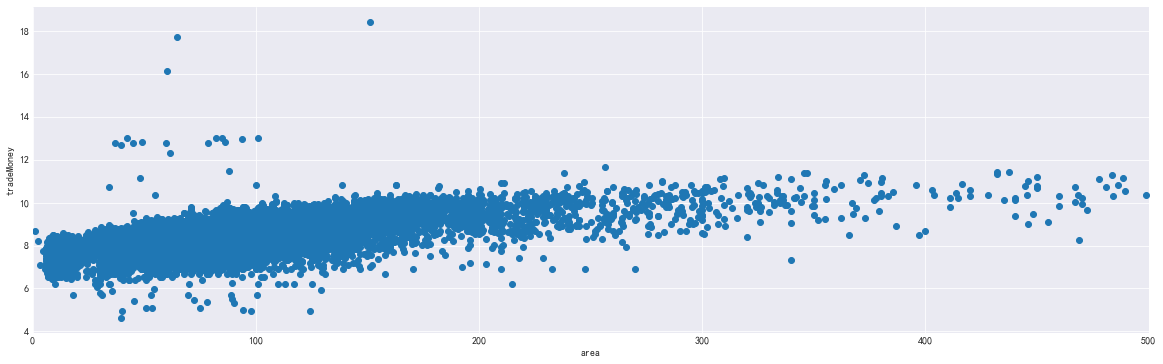

In [91]:
#########################数值型变量探索性分析
############房屋面积与房屋租金关系散点图
f,ax = plt.subplots(figsize=(20,6))
plt.xlabel('area')
plt.ylabel('tradeMoney')
plt.xlim(0,500)
plt.scatter(house_train['area'],house_train['tradeMoney'])
plt.show()

上图显示：随着面积的增加，房屋租金整体上逐渐上涨。大多数房屋面积在200平以下。

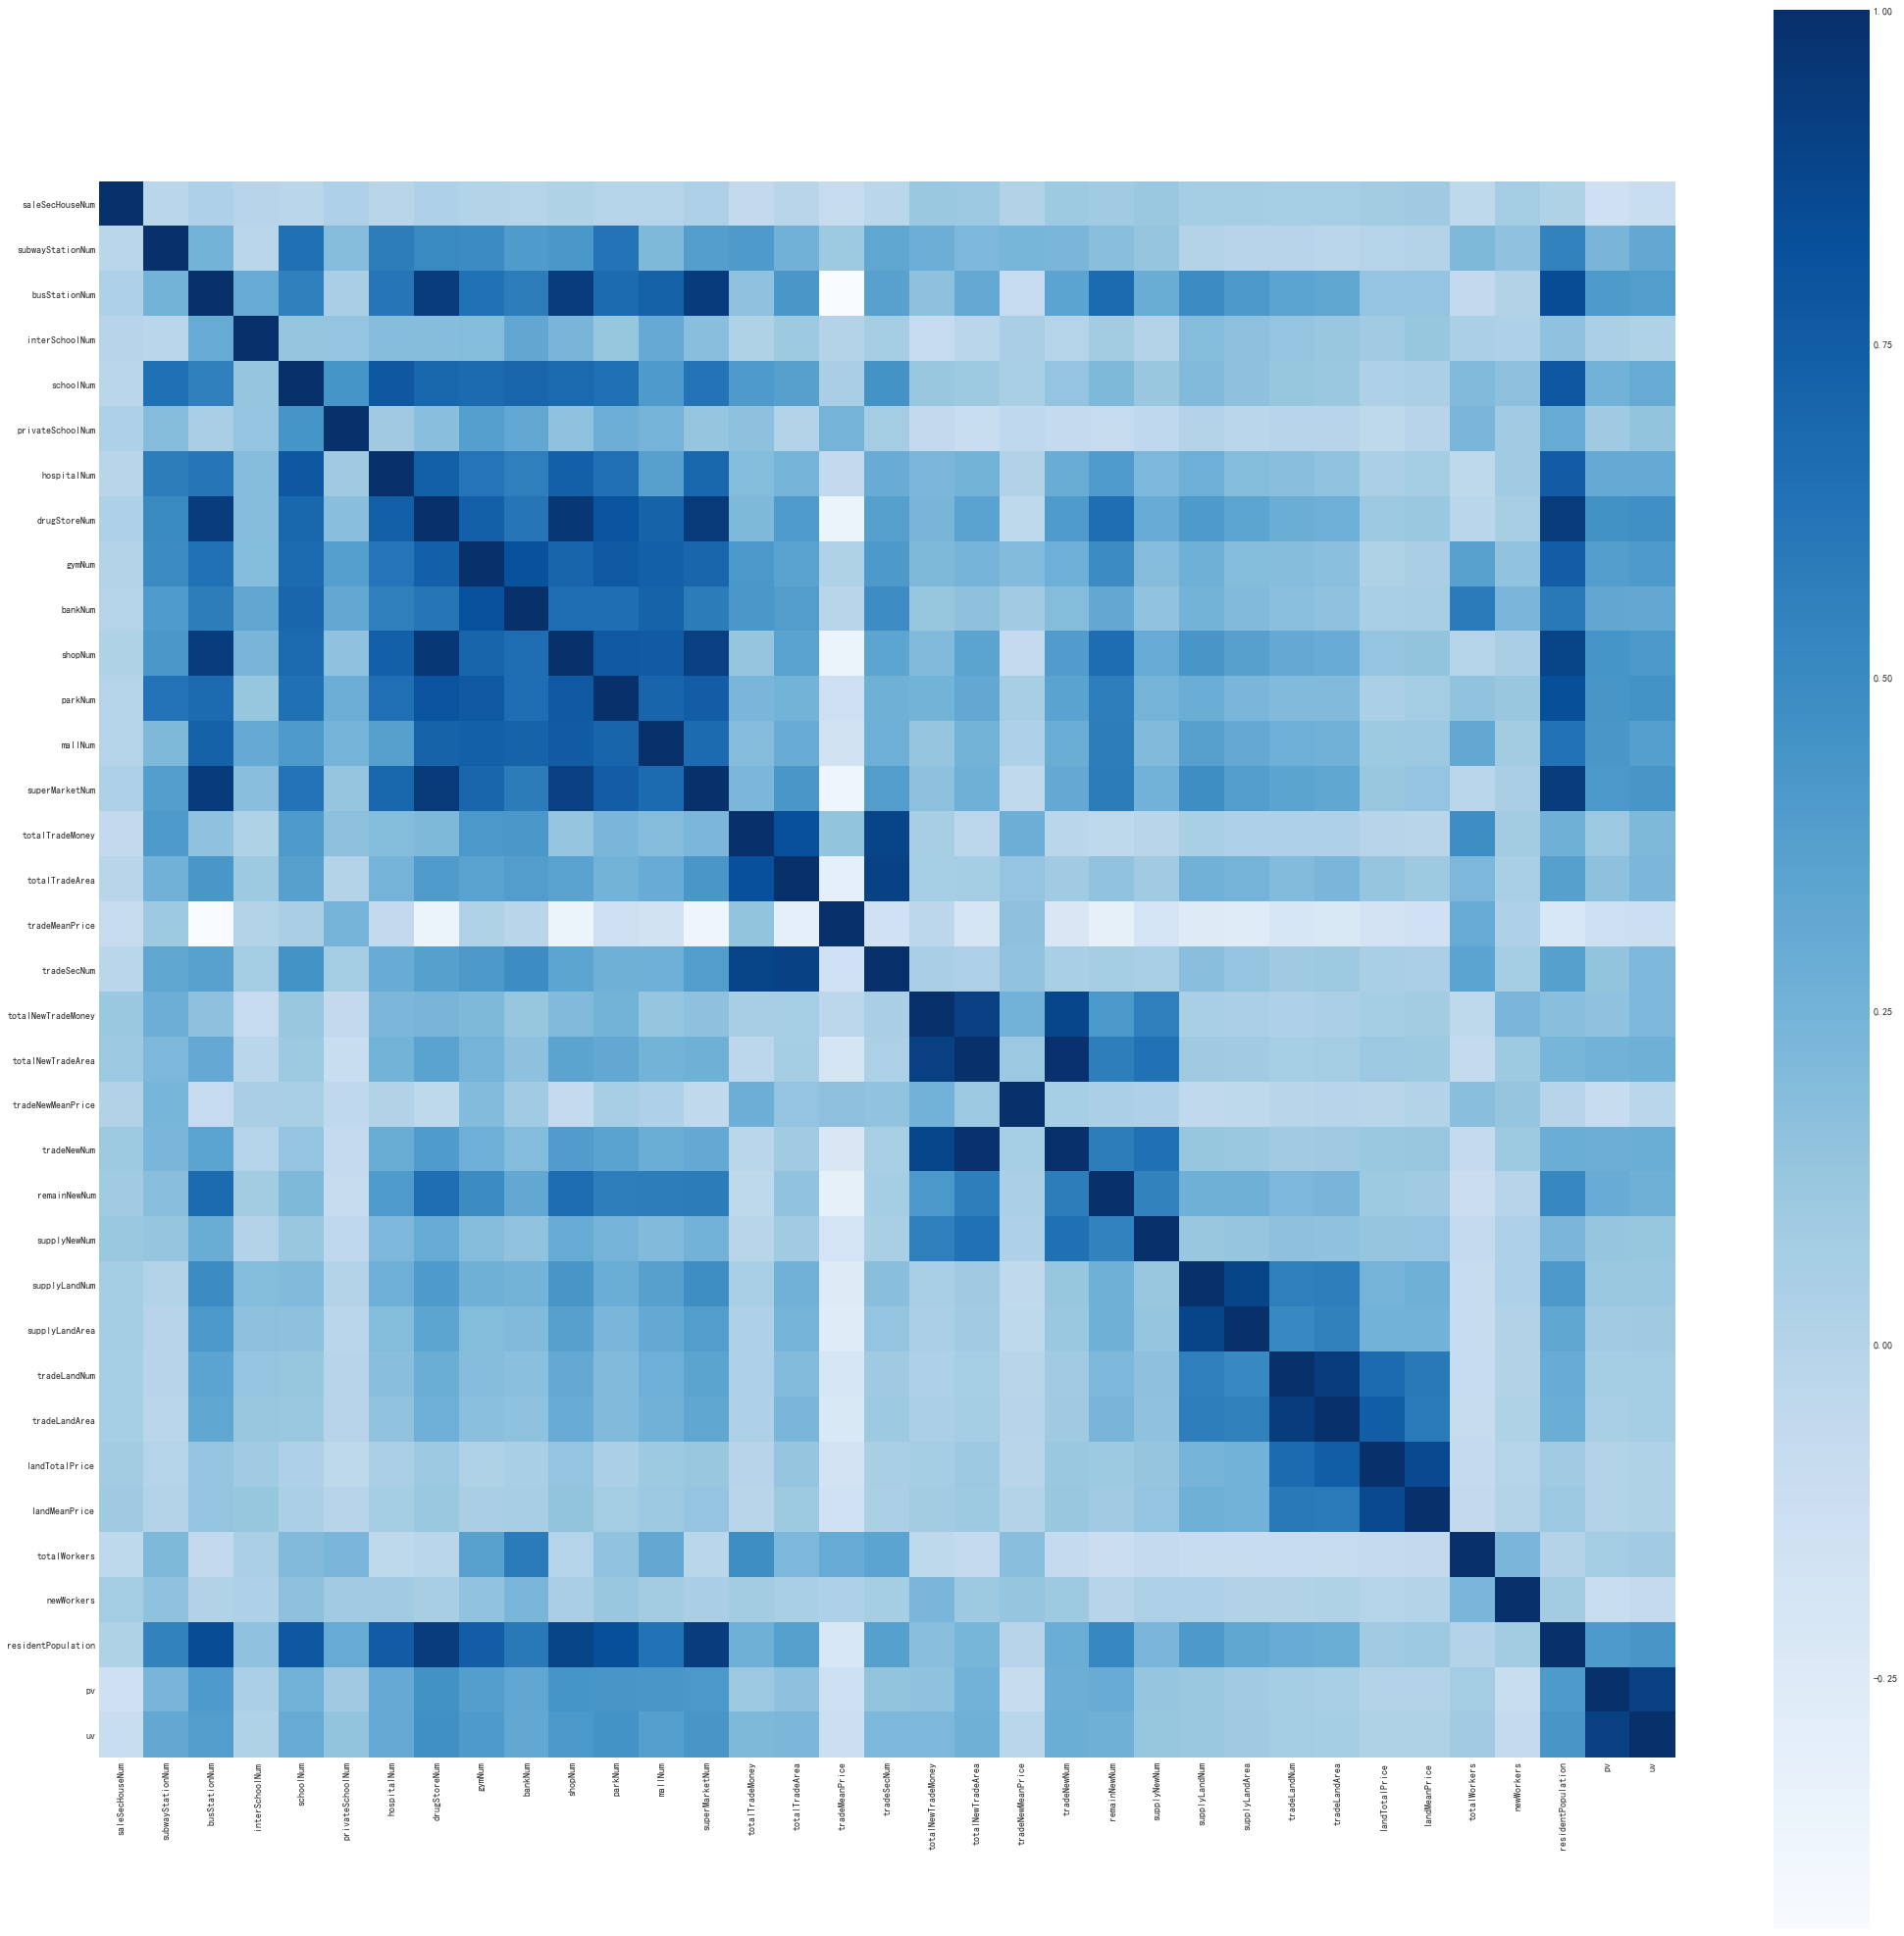

In [95]:
###################数值型变量之间的相关性展示
plt.subplots(figsize=(36,36))
sns.heatmap(house_train.iloc[:,13:48].corr(), annot=False, vmax=1, square=True, cmap="Blues")
plt.show()

In [ ]:
从上图可以看出：数值变量之间相关性整体上不高，有部分变量之间有较高的相关性(比如UV和PV),在进行特征工程时需要将相关性过高的变量选择性剔除。